<a href="https://colab.research.google.com/github/21016118uhi/21016118_DataAnalytics/blob/main/21016118_assignment_part2_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
# set seed for repeatability
import os
os.environ['PYTHONHASHSEED'] = '0'

In [128]:
# import necessary packages
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
print(tf.__version__)

2.15.0


In [129]:
# enable deterministic operations and set seeds for repeatability
tf.config.experimental.enable_op_determinism()
tf.keras.utils.set_random_seed(7)
tf.random.set_seed(7)

# Introduction

New York's emergency services asked whether there is a relationship between the weather and the number of collisions on a specified day. It is assumed that this is to understand whether this can be used to improve resource planning by being able to predict the number of collisions. Earlier analysis of the data suggested the best fitting model should be a simple linear model based on temperature, windspeed, sea-level pressure, precipitation, visibility, fog, average speed, and date information. This will be tested in this report.

# Methodology

Two linear models were created and two deep neural network regressor models. These were trained and tested before being validated against a sample of known values.

### Data preparation

In preparation, the rows in the dataset were shuffled to prevent inherited bias which might impact the fit of the model. Shown below are the first ten rows of this dataframe.

In [130]:
# read in data
cwt_full = pd.read_csv("https://raw.githubusercontent.com/21016118uhi/21016118_DataAnalytics/main/combined_collisions_weather_traffic_FINAL.csv")

# create dataframe by selecting relevant columns
cwt_df1 = cwt_full[['total_collisions', 'month', 'day_of_week', 'temp_c', 'slp_c', 'visib_c', 'wdsp_c', 'prcp_c', 'fog_c', 'avg_speed_all']]

# shuffle data
shuffle_df1 = cwt_df1.iloc[np.random.permutation(len(cwt_df1))]

# review first 10 rows of data
print(shuffle_df1[:10])

     total_collisions  month  day_of_week  temp_c   slp_c  visib_c  wdsp_c  \
114               236      5            3    51.5   998.2      9.5    12.1   
129               316      5            4    54.2  1003.6      8.8    16.1   
302               260     11            2    50.8  1007.0      8.7    17.0   
256               267     10            5    58.5  1011.9      9.3     5.1   
160               270      7            4    68.6  1014.6      4.1     4.4   
230               280      9            7    62.9  1003.9      9.1    22.1   
332               229     12            4    45.9  1019.9      5.7     4.0   
65                264      3            3    42.1   998.2      7.6    17.8   
296               354     11            3    38.7  1033.0     10.0     8.8   
122               257      5            4    51.4  1019.1     10.0    10.1   

     prcp_c  fog_c  avg_speed_all  
114    0.02      0      28.936996  
129    0.00      0      27.530219  
302    0.13      0      30.493639

In [131]:
# create one hot encodeing of month and day of week
encoded_month = pd.get_dummies(shuffle_df1['month']).add_prefix('mon_')
encoded_day_of_week = pd.get_dummies(shuffle_df1['day_of_week']).add_prefix('dow_')

Each of the columns of the data was then scaled based on the mean, minimum and maximum. One hot encoding was applied to the month and day of the week columns.

In [132]:
# values stored so scaling can be reversed later when predictions are calculated
total_collisions_mean = shuffle_df1.loc[:, 'total_collisions'].mean()
total_collisions_min = shuffle_df1.loc[:, 'total_collisions'].min()
total_collisions_max = shuffle_df1.loc[:, 'total_collisions'].max()

In [133]:
# set up scaler
scaler = MinMaxScaler()

# scale dataset
shuffle_df1[shuffle_df1.columns] = scaler.fit_transform(shuffle_df1[shuffle_df1.columns])

In [134]:
# add one hot encoding to dataframe
df1_ohe = shuffle_df1.join(encoded_month).join(encoded_day_of_week)

# print head of dataframe
print(df1_ohe.head())

     total_collisions     month  day_of_week    temp_c     slp_c   visib_c  \
114          0.399038  0.363636     0.333333  0.649928  0.142157  0.943820   
129          0.783654  0.363636     0.500000  0.688666  0.274510  0.865169   
302          0.514423  0.909091     0.166667  0.639885  0.357843  0.853933   
256          0.548077  0.818182     0.666667  0.750359  0.477941  0.921348   
160          0.562500  0.545455     0.500000  0.895265  0.544118  0.337079   

       wdsp_c    prcp_c  fog_c  avg_speed_all  ...  mon_10  mon_11  mon_12  \
114  0.387234  0.012903    0.0       0.425176  ...       0       0       0   
129  0.557447  0.000000    0.0       0.345383  ...       0       0       0   
302  0.595745  0.083871    0.0       0.513470  ...       0       1       0   
256  0.089362  0.000000    0.0       0.215837  ...       1       0       0   
160  0.059574  0.000000    1.0       0.284028  ...       0       0       0   

     dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  dow_7  
114    

The final preparation step was to reserve 5% of the data for model validation.

In [135]:
# create a building dataset and validation dataset
df1_build = df1_ohe.sample(frac=0.95, random_state=0)
df1_validate = df1_ohe.drop(df1_build.index)

df1_build.shape

(318, 29)

The dataframe to be used for building the models contains 318 rows.

In [136]:
df1_validate.shape

(17, 29)

The validation dataframe has just 17 rows.

### Linear regression models

The first model to be trained and tested was a linear model that uses all the weather variables.

In [137]:
# create a dataframe with the predictors and target at the end using the shuffled dataframe
df1_input_data_weather = [df1_build["temp_c"], df1_build["slp_c"], df1_build["visib_c"], df1_build["wdsp_c"], df1_build["prcp_c"], df1_build["fog_c"], df1_build["total_collisions"]]
# create headers
df1_input_headers_weather = ["temp", "slp", "visib", "wdsp", "prcp", "fog", "total_collisions"]
# combine data and headers
df1_input_weather = pd.concat(df1_input_data_weather, axis=1, keys=df1_input_headers_weather)

# create a training dataset and test dataset
training_df1_weather = df1_input_weather.sample(frac=0.7, random_state=0)
test_df1_weather = df1_input_weather.drop(training_df1_weather.index)

# create copies and remove target
training_features_df1_weather = training_df1_weather.copy()
test_features_df1_weather = test_df1_weather.copy()

training_labels_df1_weather = training_features_df1_weather.pop("total_collisions")
test_labels_df1_weather = test_features_df1_weather.pop("total_collisions")

# create normalisation layer
normaliser_weather = tf.keras.layers.Normalization(axis=-1)
normaliser_weather.adapt(np.array(training_features_df1_weather))

# create model and add normalisation layer
m1 = tf.keras.Sequential([
    normaliser_weather,
    layers.Dense(units=1)
])

# creating sequential model with optimiser and loss parameter (MAE)
m1.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# fit the model with training data, run 1000 times with 20% validation split
history = m1.fit(
    training_features_df1_weather,
    training_labels_df1_weather,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# check mean absolute error
MAE_m1 = m1.evaluate(
    test_features_df1_weather,
    test_labels_df1_weather, verbose=0)
print(MAE_m1)

0.15897241234779358


The mean absolute error of this initial model using just the weather variables was 0.159.

The analysis suggested that the model should be improved by adding date information. This was the next version of the model to be trained and tested.

In [138]:
# create a dataframe with the predictors and target at the end using the shuffled dataframe
df1_input_data_weather_date = [df1_build["temp_c"], df1_build["slp_c"], df1_build["visib_c"], df1_build["wdsp_c"], df1_build["prcp_c"], df1_build["fog_c"], df1_build["mon_1"], df1_build["mon_2"], df1_build["mon_3"], df1_build["mon_4"], df1_build["mon_5"], df1_build["mon_6"], df1_build["mon_7"], df1_build["mon_8"], df1_build["mon_9"], df1_build["mon_10"], df1_build["mon_11"], df1_build["mon_12"], df1_build["dow_1"], df1_build["dow_2"], df1_build["dow_3"], df1_build["dow_4"], df1_build["dow_5"], df1_build["dow_6"], df1_build["dow_7"], df1_build["total_collisions"]]
# create headers
df1_input_headers_weather_date = ["temp", "slp", "visib", "wdsp", "prcp", "fog", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "total_collisions"]
# combine data and headers
df1_input_weather_date = pd.concat(df1_input_data_weather_date, axis=1, keys=df1_input_headers_weather_date)

# create a training dataset and test dataset
training_df1_weather_date = df1_input_weather_date.sample(frac=0.7, random_state=0)
test_df1_weather_date = df1_input_weather_date.drop(training_df1_weather_date.index)

# create copies and remove target
training_features_df1_weather_date = training_df1_weather_date.copy()
test_features_df1_weather_date = test_df1_weather_date.copy()

training_labels_df1_weather_date = training_features_df1_weather_date.pop("total_collisions")
test_labels_df1_weather_date = test_features_df1_weather_date.pop("total_collisions")

# create normalisation layer
normaliser_weather_date = tf.keras.layers.Normalization(axis=-1)
normaliser_weather_date.adapt(np.array(training_features_df1_weather_date))

# create additional model and add normalisation layer
m2 = tf.keras.Sequential([
    normaliser_weather_date,
    layers.Dense(units=1)
])

# creating sequential model with optimiser and loss parameter (MAE)
m2.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# fit the model with training data, run 1000 times with 20% validation split
history = m2.fit(
    training_features_df1_weather_date,
    training_labels_df1_weather_date,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# check mean absolute error
MAE_m2 = m2.evaluate(
    test_features_df1_weather_date,
    test_labels_df1_weather_date, verbose=0)
print(MAE_m2)

0.2234266996383667


However, testing suggested it produced a higher mean absolute error (0.223). It is possible that the variation between months is related to the changes in weather over the year. This will be considered later.

As per the analysis results, a further model was created with average speed, to see if this reduced the mean absolute error.

In [139]:
# create a dataframe with the predictors and target at the end using the shuffled dataframe
df1_input_data_weather_date_speed = [df1_build["temp_c"], df1_build["slp_c"], df1_build["visib_c"], df1_build["wdsp_c"], df1_build["prcp_c"], df1_build["fog_c"], df1_build["mon_1"], df1_build["mon_2"], df1_build["mon_3"], df1_build["mon_4"], df1_build["mon_5"], df1_build["mon_6"], df1_build["mon_7"], df1_build["mon_8"], df1_build["mon_9"], df1_build["mon_10"], df1_build["mon_11"], df1_build["mon_12"], df1_build["dow_1"], df1_build["dow_2"], df1_build["dow_3"], df1_build["dow_4"], df1_build["dow_5"], df1_build["dow_6"], df1_build["dow_7"], df1_build["avg_speed_all"], df1_build["total_collisions"]]
# create headers
df1_input_headers_weather_date_speed = ["temp", "slp", "visib", "wdsp", "prcp", "fog", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "avg_speed", "total_collisions"]
# combine data and headers
df1_input_weather_date_speed = pd.concat(df1_input_data_weather_date_speed, axis=1, keys=df1_input_headers_weather_date_speed)

# create a training dataset and test dataset
training_df1_weather_date_speed = df1_input_weather_date_speed.sample(frac=0.7, random_state=0)
test_df1_weather_date_speed = df1_input_weather_date_speed.drop(training_df1_weather_date_speed.index)

# create copies and remove target
training_features_df1_weather_date_speed = training_df1_weather_date_speed.copy()
test_features_df1_weather_date_speed = test_df1_weather_date_speed.copy()

training_labels_df1_weather_date_speed = training_features_df1_weather_date_speed.pop("total_collisions")
test_labels_df1_weather_date_speed = test_features_df1_weather_date_speed.pop("total_collisions")

# create normalisation layer
normaliser_weather_date_speed = tf.keras.layers.Normalization(axis=-1)
normaliser_weather_date_speed.adapt(np.array(training_features_df1_weather_date_speed))

# create additional model and add normalisation layer
m3 = tf.keras.Sequential([
    normaliser_weather_date_speed,
    layers.Dense(units=1)
])

# creating sequential model with optimiser and loss parameter (MAE)
m3.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# fit the model with training data, run 1000 times with 20% validation split
history = m3.fit(
    training_features_df1_weather_date_speed,
    training_labels_df1_weather_date_speed,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# check mean absolute error
MAE_m3 = m3.evaluate(
    test_features_df1_weather_date_speed,
    test_labels_df1_weather_date_speed, verbose=0)
print(MAE_m3)

0.18590649962425232


This did decrease the mean absolute error (0.186), but is still larger than the model using just weather variables (0.159).

It was suspected that the month variable could be the cause of the error, as it tracks the change in season, which is also tracked through the weather variables. The model was further refined by using only the weather variables, day of the week and average speed.

In [140]:
# create a dataframe with the predictors and target at the end using the shuffled dataframe
df1_input_data_weather_dow_speed = [df1_build["temp_c"], df1_build["slp_c"], df1_build["visib_c"], df1_build["wdsp_c"], df1_build["prcp_c"], df1_build["fog_c"], df1_build["dow_1"], df1_build["dow_2"], df1_build["dow_3"], df1_build["dow_4"], df1_build["dow_5"], df1_build["dow_6"], df1_build["dow_7"], df1_build["avg_speed_all"], df1_build["total_collisions"]]
# create headers
df1_input_headers_weather_dow_speed = ["temp", "slp", "visib", "wdsp", "prcp", "fog", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "avg_speed", "total_collisions"]
# combine data and headers
df1_input_weather_dow_speed = pd.concat(df1_input_data_weather_dow_speed, axis=1, keys=df1_input_headers_weather_dow_speed)

# create a training dataset and test dataset
training_df1_weather_dow_speed = df1_input_weather_dow_speed.sample(frac=0.7, random_state=0)
test_df1_weather_dow_speed = df1_input_weather_dow_speed.drop(training_df1_weather_dow_speed.index)

# create copies and remove target
training_features_df1_weather_dow_speed = training_df1_weather_dow_speed.copy()
test_features_df1_weather_dow_speed = test_df1_weather_dow_speed.copy()

training_labels_df1_weather_dow_speed = training_features_df1_weather_dow_speed.pop("total_collisions")
test_labels_df1_weather_dow_speed = test_features_df1_weather_dow_speed.pop("total_collisions")

# create normalisation layer
normaliser_weather_dow_speed = tf.keras.layers.Normalization(axis=-1)
normaliser_weather_dow_speed.adapt(np.array(training_features_df1_weather_dow_speed))

# create additional model and add normalisation layer
m4 = tf.keras.Sequential([
    normaliser_weather_dow_speed,
    layers.Dense(units=1)
])

# creating sequential model with optimiser and loss parameter (MAE)
m4.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# fit the model with training data, run 1000 times with 20% validation split
history = m4.fit(
    training_features_df1_weather_dow_speed,
    training_labels_df1_weather_dow_speed,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# check mean absolute error
MAE_m4 = m4.evaluate(
    test_features_df1_weather_dow_speed,
    test_labels_df1_weather_dow_speed, verbose=0)
print(MAE_m4)

0.11993241310119629


Removing month produced a model with the lowest mean absolute error: 0.120.

Finally, a model was created without average speed, as it is unlikely this will be known many days in advance for future planning.

In [141]:
# create a dataframe with the predictors and target at the end using the shuffled dataframe
df1_input_data_weather_dow = [df1_build["temp_c"], df1_build["slp_c"], df1_build["visib_c"], df1_build["wdsp_c"], df1_build["prcp_c"], df1_build["fog_c"], df1_build["dow_1"], df1_build["dow_2"], df1_build["dow_3"], df1_build["dow_4"], df1_build["dow_5"], df1_build["dow_6"], df1_build["dow_7"], df1_build["total_collisions"]]
# create headers
df1_input_headers_weather_dow = ["temp", "slp", "visib", "wdsp", "prcp", "fog", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "total_collisions"]
# combine data and headers
df1_input_weather_dow = pd.concat(df1_input_data_weather_dow, axis=1, keys=df1_input_headers_weather_dow)

# create a training dataset and test dataset
training_df1_weather_dow = df1_input_weather_dow.sample(frac=0.7, random_state=0)
test_df1_weather_dow = df1_input_weather_dow.drop(training_df1_weather_dow.index)

# create copies and remove target
training_features_df1_weather_dow = training_df1_weather_dow.copy()
test_features_df1_weather_dow = test_df1_weather_dow.copy()

training_labels_df1_weather_dow = training_features_df1_weather_dow.pop("total_collisions")
test_labels_df1_weather_dow = test_features_df1_weather_dow.pop("total_collisions")

# create normalisation layer
normaliser_weather_dow = tf.keras.layers.Normalization(axis=-1)
normaliser_weather_dow.adapt(np.array(training_features_df1_weather_dow))

# create additional model and add normalisation layer
m5 = tf.keras.Sequential([
    normaliser_weather_dow,
    layers.Dense(units=1)
])

# creating sequential model with optimiser and loss parameter (MAE)
m5.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# fit the model with training data, run 1000 times with 20% validation split
history = m5.fit(
    training_features_df1_weather_dow,
    training_labels_df1_weather_dow,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# check mean absolute error
MAE_m5 = m5.evaluate(
    test_features_df1_weather_dow,
    test_labels_df1_weather_dow, verbose=0)
print(MAE_m5)

0.12271690368652344


This second model had a mean absolute error of 0.123, which was lower than the model using just weather variables, although not as low as the model that uses average speed as was expected.

### Deep Neural Network Regressors

The linear regression models created above were then used to train deep neural network regressors to check for additional non-linear effects between the variables and better understand whether weather can be used to predict the number of collisions on a specific day.

In [142]:
# Check the dataframe size
df1_input_weather_dow_speed.shape

(318, 15)

As the first linear model contains 14 variables, the first model tested used a single hidden layer and 8 neurons (the mean of the input and output neurons).

In [143]:
# design model
dnn_m1 = keras.Sequential([
      normaliser_weather_dow_speed,
      layers.Dense(8, activation='relu'),
      layers.Dense(1)
  ])

dnn_m1.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

# fit model
history = dnn_m1.fit(
    training_features_df1_weather_dow_speed,
    training_labels_df1_weather_dow_speed,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# test model
MAE_dnn_m1 = dnn_m1.evaluate(
    test_features_df1_weather_dow_speed,
    test_labels_df1_weather_dow_speed, verbose=0)
print(MAE_dnn_m1)

0.13904285430908203


The mean absolute error of this model was 0.139, slightly higher than the linear regression model. To reduce this, two further models were tested: The first increased the number of neurons to eleven (number of samples divided by two times the combined total of input and output neurons) and the second added an additional hidden layer.

In [144]:
# design model
dnn_m2 = keras.Sequential([
      normaliser_weather_dow_speed,
      layers.Dense(11, activation='relu'),
      layers.Dense(1)
  ])

dnn_m2.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

# fit model
history = dnn_m2.fit(
    training_features_df1_weather_dow_speed,
    training_labels_df1_weather_dow_speed,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# test model
MAE_dnn_m2 = dnn_m2.evaluate(
    test_features_df1_weather_dow_speed,
    test_labels_df1_weather_dow_speed, verbose=0)
print(MAE_dnn_m2)

0.12315217405557632


In [145]:
# design model
dnn_m3 = keras.Sequential([
      normaliser_weather_dow_speed,
      layers.Dense(8, activation='relu'),
      layers.Dense(8, activation='relu'),
      layers.Dense(1)
  ])

dnn_m3.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

# fit model
history = dnn_m3.fit(
    training_features_df1_weather_dow_speed,
    training_labels_df1_weather_dow_speed,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# test model
MAE_dnn_m3 = dnn_m3.evaluate(
    test_features_df1_weather_dow_speed,
    test_labels_df1_weather_dow_speed, verbose=0)
print(MAE_dnn_m3)

0.1537146270275116


The model that increased the number of neurons had a smaller mean absolute error, but increasing the number of hidden layers increased the mean absolute error. Further models were tested using a single hidden layer to establish the optimal number of neurons to minimise the mean absolute error.

In [146]:
# design model
dnn_m4 = keras.Sequential([
      normaliser_weather_dow_speed,
      layers.Dense(10, activation='relu'),
      layers.Dense(1)
  ])

dnn_m4.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

# fit model
history = dnn_m4.fit(
    training_features_df1_weather_dow_speed,
    training_labels_df1_weather_dow_speed,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# test model
MAE_dnn_m4 = dnn_m4.evaluate(
    test_features_df1_weather_dow_speed,
    test_labels_df1_weather_dow_speed, verbose=0)
print(MAE_dnn_m4)

0.1505570113658905


In [147]:
# design model
dnn_m5 = keras.Sequential([
      normaliser_weather_dow_speed,
      layers.Dense(12, activation='relu'),
      layers.Dense(1)
  ])

dnn_m5.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

# fit model
history = dnn_m5.fit(
    training_features_df1_weather_dow_speed,
    training_labels_df1_weather_dow_speed,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# test model
MAE_dnn_m5 = dnn_m5.evaluate(
    test_features_df1_weather_dow_speed,
    test_labels_df1_weather_dow_speed, verbose=0)
print(MAE_dnn_m5)

0.15924003720283508


Further tests using models with higher and lower neurons did not produce a lower mean absolute error, therefore, the model is optimised when it has a single hidden layer with 11 neurons.

These steps were then repeated using the variables from the second linear regression model for the second deep neural network regressor model.

In [148]:
# design model
dnn_m6 = keras.Sequential([
      normaliser_weather_dow,
      layers.Dense(8, activation='relu'),
      layers.Dense(1)
  ])

dnn_m6.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

# fit model
history = dnn_m6.fit(
    training_features_df1_weather_dow,
    training_labels_df1_weather_dow,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# test model
MAE_dnn_m6 = dnn_m6.evaluate(
    test_features_df1_weather_dow,
    test_labels_df1_weather_dow, verbose=0)
print(MAE_dnn_m6)

0.13832999765872955


In [149]:
# design model
dnn_m7 = keras.Sequential([
      normaliser_weather_dow,
      layers.Dense(8, activation='relu'),
      layers.Dense(8, activation='relu'),
      layers.Dense(1)
  ])

dnn_m7.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

# fit model
history = dnn_m7.fit(
    training_features_df1_weather_dow,
    training_labels_df1_weather_dow,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# test model
MAE_dnn_m7 = dnn_m7.evaluate(
    test_features_df1_weather_dow,
    test_labels_df1_weather_dow, verbose=0)
print(MAE_dnn_m7)

0.15465085208415985


In [150]:
# design model
dnn_m8 = keras.Sequential([
      normaliser_weather_dow,
      layers.Dense(11, activation='relu'),
      layers.Dense(1)
  ])

dnn_m8.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

# fit model
history = dnn_m8.fit(
    training_features_df1_weather_dow,
    training_labels_df1_weather_dow,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# test model
MAE_dnn_m8 = dnn_m8.evaluate(
    test_features_df1_weather_dow,
    test_labels_df1_weather_dow, verbose=0)
print(MAE_dnn_m8)

0.1522296518087387


In [151]:
# design model
dnn_m9 = keras.Sequential([
      normaliser_weather_dow,
      layers.Dense(9, activation='relu'),
      layers.Dense(1)
  ])

dnn_m9.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

# fit model
history = dnn_m9.fit(
    training_features_df1_weather_dow,
    training_labels_df1_weather_dow,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# test model
MAE_dnn_m9 = dnn_m9.evaluate(
    test_features_df1_weather_dow,
    test_labels_df1_weather_dow, verbose=0)
print(MAE_dnn_m9)

0.1608976423740387


In [152]:
# design model
dnn_m10 = keras.Sequential([
      normaliser_weather_dow,
      layers.Dense(7, activation='relu'),
      layers.Dense(1)
  ])

dnn_m10.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

# fit model
history = dnn_m10.fit(
    training_features_df1_weather_dow,
    training_labels_df1_weather_dow,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# test model
MAE_dnn_m10 = dnn_m10.evaluate(
    test_features_df1_weather_dow,
    test_labels_df1_weather_dow, verbose=0)
print(MAE_dnn_m10)

0.1315169483423233


In [153]:
# design model
dnn_m11 = keras.Sequential([
      normaliser_weather_dow,
      layers.Dense(6, activation='relu'),
      layers.Dense(1)
  ])

dnn_m11.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

# fit model
history = dnn_m11.fit(
    training_features_df1_weather_dow,
    training_labels_df1_weather_dow,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

# test model
MAE_dnn_m11 = dnn_m11.evaluate(
    test_features_df1_weather_dow,
    test_labels_df1_weather_dow, verbose=0)
print(MAE_dnn_m11)

0.13761399686336517


Using seven neurons and one hidden layer produced a mean absolute error of 0.132. This was the most improved model compared to adding an addition hidden layer or varying the number of neurons.

# Results

To understand if there is a relationship between the weather and the number of collisions, a set of linear regression and deep neural network regressor models were designed using information about the weather (temperature, sea level pressure, visibility, windspeed, precipitation and fog) and day of the week. One set also included average speed information. These will be tested using the inputs from validation dataframe in turn to understand how well they are able to predict the number of actual collisions. Shown below is the validation dataframe.

In [154]:
# create a dataframe with the predictors and target at the end using the shuffled dataframe
df1_validate_data_weather_dow_speed = [df1_validate["temp_c"], df1_validate["slp_c"], df1_validate["visib_c"], df1_validate["wdsp_c"], df1_validate["prcp_c"], df1_validate["fog_c"], df1_validate["dow_1"], df1_validate["dow_2"], df1_validate["dow_3"], df1_validate["dow_4"], df1_validate["dow_5"], df1_validate["dow_6"], df1_validate["dow_7"], df1_validate["avg_speed_all"], df1_validate["total_collisions"]]
# create headers
df1_validate_headers_weather_dow_speed = ["temp", "slp", "visib", "wdsp", "prcp", "fog", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "avg_speed", "total_collisions"]
# combine data and headers
df1_validate_weather_dow_speed = pd.concat(df1_validate_data_weather_dow_speed, axis=1, keys=df1_validate_headers_weather_dow_speed)
df1_validate_weather_dow_speed = df1_validate_weather_dow_speed.reset_index(drop=True)

print(df1_validate_weather_dow_speed)


        temp       slp     visib      wdsp      prcp  fog  Sun  Mon  Tue  Wed  \
0   0.648494  0.654412  1.000000  0.302128  0.000000  0.0    0    0    0    1   
1   0.497848  0.607843  1.000000  0.502128  0.000000  0.0    0    0    0    0   
2   0.459110  0.147059  0.921348  0.753191  0.148387  0.0    0    0    0    1   
3   0.492109  0.338235  1.000000  0.353191  0.064516  0.0    0    0    1    0   
4   0.480631  0.759804  1.000000  0.217021  0.000000  0.0    0    0    0    0   
5   0.890961  0.487745  1.000000  0.370213  0.012903  0.0    0    0    0    0   
6   0.492109  0.634804  1.000000  0.425532  0.000000  0.0    0    0    0    0   
7   0.684362  0.718137  1.000000  0.114894  0.000000  0.0    0    0    0    0   
8   0.787661  0.411765  0.955056  0.212766  0.109677  0.0    1    0    0    0   
9   0.835007  0.705882  1.000000  0.148936  0.000000  0.0    0    0    0    0   
10  0.961263  0.424020  0.910112  0.140426  0.000000  0.0    0    0    0    1   
11  1.000000  0.526961  0.83

In [155]:
print("Train/Test LR:", MAE_m4)
print("Train/Test DNN:", MAE_dnn_m2)

Train/Test LR: 0.11993241310119629
Train/Test DNN: 0.12315217405557632


In training, the linear regression model produced a mean absolute error value of 0.120, compared to the deep neural network regressor model with a mean absolute error value of 0.123. Based on these results, the linear regression model is expected to be slightly better at predicting the number of collisions.

In [156]:
# derive predictions using linear model
linear_predictions = m4.predict(df1_validate_weather_dow_speed.loc[:, df1_validate_weather_dow_speed.columns != 'total_collisions'])
df_predictions_lr = pd.DataFrame(linear_predictions, columns = ['predictions_lr'])

# derive predictions using dnn
dnn_predictions = dnn_m2.predict(df1_validate_weather_dow_speed.loc[:, df1_validate_weather_dow_speed.columns != 'total_collisions'])
df_predictions_dnn = pd.DataFrame(dnn_predictions, columns = ['predictions_dnn'])

# add predictions to table
m1_final = df1_validate_weather_dow_speed.join(df_predictions_lr).join(df_predictions_dnn)

1/1 [==============================] - 0s 73ms/step


In [157]:
# calculate scale range
total_collisions_range = total_collisions_max - total_collisions_min

# multiple scaled values by range and add mean
m1_final['total_collisions_unscaled'] = m1_final['total_collisions'] * total_collisions_range + total_collisions_mean
m1_final['predictions_lr_unscaled'] = m1_final['predictions_lr'] * total_collisions_range + total_collisions_mean
m1_final['predictions_dnn_unscaled'] = m1_final['predictions_dnn'] * total_collisions_range + total_collisions_mean
m1_final['lr_error'] = m1_final['predictions_lr_unscaled'] - m1_final['total_collisions_unscaled']
m1_final['dnn_error'] = m1_final['predictions_dnn_unscaled'] - m1_final['total_collisions_unscaled']

# calculate mean absolute errors
MAE_lr = m1_final.loc[:, 'lr_error'].mean()
MAE_dnn = m1_final.loc[:, 'dnn_error'].mean()

In [158]:
print("MAE LR:", MAE_lr)
print("MAE DNN:", MAE_dnn)

MAE LR: 0.5886635369224343
MAE DNN: -13.679268232953484


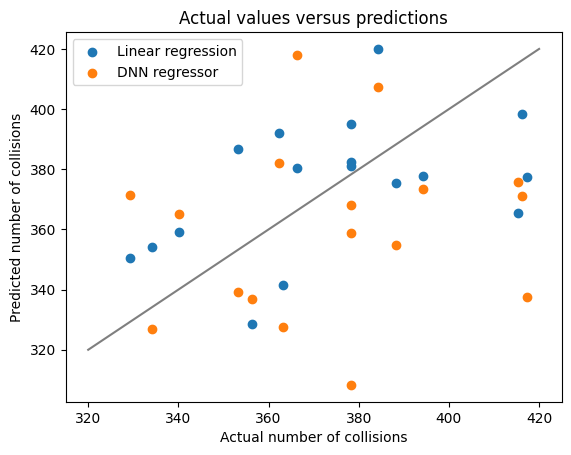

In [159]:
plt.scatter(m1_final['total_collisions_unscaled'], m1_final['predictions_lr_unscaled'])
plt.scatter(m1_final['total_collisions_unscaled'], m1_final['predictions_dnn_unscaled'])
plt.plot([320, 420], [320, 420], 'k-', alpha=0.5)
plt.title("Actual values versus predictions")
plt.xlabel("Actual number of collisions")
plt.ylabel("Predicted number of collisions")
plt.legend(['Linear regression' , 'DNN regressor'])
plt.show()

Considering only the mean absolute error of the predictions suggests that the linear model is exceedingly good at predicting the number of collisions (0.59) compared to -13.7 for the deep neural network regressor model. However, the plot reveals that in many instances the deep neural network regressor model predicted a value closer to the actual figure than the linear regression model and that there are some large errors in the results.

In [160]:
m1_final['lr_error_sq'] = m1_final['lr_error']**2
m1_final['dnn_error_sq'] = m1_final['dnn_error']**2

MSE_lr = m1_final.loc[:, 'lr_error_sq'].mean()
MSE_dnn = m1_final.loc[:, 'dnn_error_sq'].mean()

print(MSE_lr, "(", np.sqrt(MSE_lr), ")")
print(MSE_dnn, "(", np.sqrt(MSE_dnn), ")")

651.4201909917117 ( 25.522934607754486 )
1455.8562082637106 ( 38.15568382644597 )


The mean squared error was calculated for both models to better understand this. The mean squared error for the linear regression model was 651.4 compared to 1455.9 for the deep neural network regressor model, meaning it still performed better of the two. However, the predicted values are plus or minus 25.5 of the actual number of collisions on average using the linear model and plus or minus 38.2 of the actual number on average using the deep neural network regressor model.

In [161]:
tc_min = m1_final['total_collisions_unscaled'].min()
tc_max = m1_final['total_collisions_unscaled'].max()

print("Minimum collisions =", tc_min, "LR: (+/-", np.sqrt(MSE_lr)/tc_min, ")", "DNN: (+/-", np.sqrt(MSE_dnn)/tc_min, ")")
print("Maximum collisions =", tc_max, "LR: (+/-", np.sqrt(MSE_lr)/tc_max, ")", "DNN: (+/-", np.sqrt(MSE_dnn)/tc_max, ")")

Minimum collisions = 329.23582089552247 LR: (+/- 0.07752174273847853 ) DNN: (+/- 0.1158916539599561 )
Maximum collisions = 417.2358208955224 LR: (+/- 0.061171484636611616 ) DNN: (+/- 0.0914487249549945 )


To put this into perspective, the actual number of collisions in the validation dataset ranges from 329 to 417, suggesting the predicted values fall on average between plus or minus 6.1-7.8% for the linear model and 9.1-11.6% for the deep neural network model on average. This suggests both models would be able to give a good indication of the anticipated number of collisions.

However, as the model includes average speed which can only be estimated within a few hours of the event, a further set of predictions were created for the models that exclude this variable.

In [162]:
# derive predictions using linear model
linear_predictions_2 = m5.predict(df1_validate_weather_dow_speed.iloc[:, :-2])
df_predictions_lr_2 = pd.DataFrame(linear_predictions_2, columns = ['predictions_lr_2'])

# derive predictions using dnn
dnn_predictions_2 = dnn_m10.predict(df1_validate_weather_dow_speed.iloc[:, :-2])
df_predictions_dnn_2 = pd.DataFrame(dnn_predictions_2, columns = ['predictions_dnn_2'])

# add predictions to table
m1_final_2 = m1_final.join(df_predictions_lr_2).join(df_predictions_dnn_2)

# calculate linear model efficacy
m1_final_2['predictions_lr_unscaled_2'] = m1_final_2['predictions_lr_2'] * total_collisions_range + total_collisions_mean
m1_final_2['lr_error_2'] = m1_final_2['predictions_lr_unscaled_2'] - m1_final_2['total_collisions_unscaled']
m1_final_2['lr_error_sq_2'] = m1_final_2['lr_error_2']**2

MAE_lr_2 = m1_final_2.loc[:, 'lr_error_2'].mean()
MSE_lr_2 = m1_final_2.loc[:, 'lr_error_sq_2'].mean()

# calculate dnn model efficacy
m1_final_2['predictions_dnn_unscaled_2'] = m1_final_2['predictions_dnn_2'] * total_collisions_range + total_collisions_mean
m1_final_2['dnn_error_2'] = m1_final_2['predictions_dnn_unscaled_2'] - m1_final_2['total_collisions_unscaled']
m1_final_2['dnn_error_sq_2'] = m1_final_2['dnn_error_2']**2

MAE_dnn_2 = m1_final_2.loc[:, 'dnn_error_2'].mean()
MSE_dnn_2 = m1_final_2.loc[:, 'dnn_error_sq_2'].mean()

print("---LR---")
print("MAE =", MAE_lr_2)
print("MSE =", MSE_lr_2, "(", np.sqrt(MSE_lr_2), ")")
print("Minimum collisions =", tc_min, "(+/-", np.sqrt(MSE_lr_2)/tc_min, ")")
print("Maximum collisions =", tc_max, "(+/-", np.sqrt(MSE_lr_2)/tc_max, ")")

print("---DNN---")
print("MAE =", MAE_dnn_2)
print("MSE =", MSE_dnn_2, "(", np.sqrt(MSE_dnn_2), ")")
print("Minimum collisions =", tc_min, "(+/-", np.sqrt(MSE_dnn_2)/tc_min, ")")
print("Maximum collisions =", tc_max, "(+/-", np.sqrt(MSE_dnn_2)/tc_max, ")")

1/1 [==============================] - 0s 62ms/step
---LR---
MAE = -10.842607286836756
MSE = 860.1115339942244 ( 29.327658174396134 )
Minimum collisions = 329.23582089552247 (+/- 0.0890779687781992 )
Maximum collisions = 417.2358208955224 (+/- 0.07029036507807393 )
---DNN---
MAE = -21.04592077776047
MSE = 1767.357736268393 ( 42.03995404693484 )
Minimum collisions = 329.23582089552247 (+/- 0.12768948996067933 )
Maximum collisions = 417.2358208955224 (+/- 0.10075825694137086 )


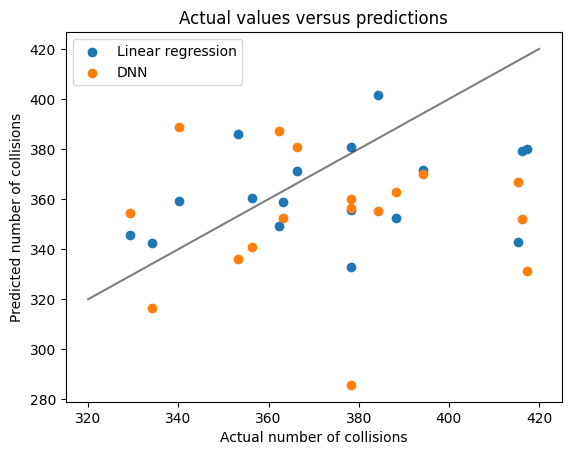

In [163]:
plt.scatter(m1_final_2['total_collisions_unscaled'], m1_final_2['predictions_lr_unscaled_2'])
plt.scatter(m1_final_2['total_collisions_unscaled'], m1_final_2['predictions_dnn_unscaled_2'])
plt.plot([320, 420], [320, 420], 'k-', alpha=0.5)
plt.title("Actual values versus predictions")
plt.xlabel("Actual number of collisions")
plt.ylabel("Predicted number of collisions")
plt.legend(['Linear regression' , 'DNN'])
plt.show()

As anticipated the linear model without average speed did not as accurately predict the number of collisions each day, with a mean absolute error of -10.8 and a mean squared error of 860.1 (suggesting the predicted values will be plus or minus 29 of the actual number of collisions). However, this should still be about plus or minus 7.0-8.9% of the actual value on average, meaning it could still be used to give an indication of the anticipate number of collisions on any given day. Similarly, the deep neural network regressor model did not perform as well as the linear regression model (mean absolute error is -21.1 and mean squared error is 1767.4), so it would be recommended that the linear model is utilised for forward planning.

# Conclusions

Previous analysis suggested that there is a relationship between the weather and the number of collisions, and this further research has demonstrated that it would be possible to use this relationship to predict the number of collisions on a specific day to aid the emergency services with resource planning with a reasonable level of accuracy.

The best model was the linear regression model that used weather, day of the week and average speed information to create predictions within plus or minus 6.1-7.8% of actual values on average (with a mean absolute error of 0.56 for the validation data and a mean squared error of 651.4). The deep neural network regressor model tested did not perform quite as well (mean absolute error of -13.7 for the validation data and a mean squared error of 1455.9).

However, it was noted that average speed would not be known as far in advance, so to help with planning, two further models were tested using only weather and day of the week information. The linear model again performed better than the deep neural network regressor model, although this was less able to accurately predict the number of collisions than with the average speed variable (mean absolute error of -10.8 and mean squared error of 860.1 for the linear regression model and mean absolute error of -21.1 and mean squared error of 1767.4 for the deep neural network regressor model). Nevertheless, the linear model should still estimate a value between 7-8.9% of the actual number of collisions on average on any specified day, which was deemed adequate for forward planning purposes.

# References

NA